<a href="https://colab.research.google.com/github/vinicius-vargas/robust-market-screener/blob/main/optimizacao_portfolio_com_reinvestimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q seaborn==0.12.2 matplotlib==3.7.0 Riskfolio-Lib pyfolio-reloaded yfinance yahooquery  plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.6/307.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.4 MB/s eta 0

In [ ]:
# @title
### Setting up libraries
import numpy as np
import pandas as pd
import requests
from io import BytesIO
import warnings

from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import yahooquery as yq

import pyfolio as pf
from pyfolio import timeseries
import riskfolio as rp

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from google.colab import  drive

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
### Extração Ações de Empresas Pagadoras de Dividendos
######################################################

# Date Range
start_train = '2010-01-01'
end_train = '2019-12-01'

live_date = '2020-01-01 00:00:00-03:00'

start_test = '2020-01-01'
end_test = (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d')

# Tickers de Ações BR
assets_br = [
    'TAEE11.SA'
    ,'EQTL3.SA'
    ,'PSSA3.SA'
    ,'ITSA4.SA'
    ,'AGRO3.SA'
    ,'FLRY3.SA'
    ,'WEGE3.SA'
    ,'CSMG3.SA'
    ,'KEPL3.SA'
    ,'FESA4.SA'
    ,'UNIP6.SA'
]

# Tickers de Ações US
assets_us = [
    'IRM'
]

# Extração Previa Dolar
db_dol = (
    yq.Ticker('BRL=X').history(start = start_train, end = end_test, interval = '1d')
    .reset_index(0)
    [lambda x: pd.to_datetime(x.index, utc=True).dayofweek < 5]
)

# Load all data
data = pd.DataFrame()

for i in (assets_br + assets_us):

  df = (
      yq.Ticker(i)
      .history(start = start_train, end = end_test, interval = '1d')
      .reset_index(0)
      [lambda x: pd.to_datetime(x.index).dayofweek < 5]
      .assign(
        adjclose = lambda x: np.where(i in assets_us, x['adjclose'] * db_dol[db_dol.index.isin(x.index)]['adjclose'], x['adjclose'])
        ,dividends = lambda x: np.where(i in assets_us, x['dividends'] * db_dol[db_dol.index.isin(x.index)]['adjclose'], x['dividends'])
      )
      [['adjclose', 'dividends']]
      .fillna(method='ffill')
  )

  data[i] = df['adjclose']
  data['div_' + i] = df['dividends']


data.index = pd.to_datetime(data.index).tz_localize('UTC')
data = data.fillna(method='ffill')


### Calculo Reinvestimento de Dividendos
########################################

amount_asset = 100000 / len(assets_br + assets_us)

for c in data[assets_br + assets_us]:

  data['qtd_pst_' + c] = round(amount_asset / data[c].head(1), 0)

  for i in range(1, len(data)):

    if data['div_' + c][i-90] > 0:
      data['qtd_pst_' + c][i] = round(
          data['qtd_pst_' + c][i-1]
          + ((data['div_' + c][i-90] * data['qtd_pst_' + c][i-1] * 0.9) / data[c][i])
          , 0
        )
    else:
      data['qtd_pst_' + c][i] = data['qtd_pst_' + c][i-1]

  data['*' + c] = data['qtd_pst_' + c] * data[c]


div_data = data[data.filter(like='*').columns]
div_data.index = pd.to_datetime(div_data.index)
div_data.index = div_data.index.tz_convert('UTC')

In [ ]:
### Extração ETFs Renda Fixa Brasil
###################################

# Lista de URLs dos arquivos Excel - IMAB - Desde 2003
urls = [
    'https://adata-precos-prod.s3.amazonaws.com/arquivos/indices-historico/IMAB5-HISTORICO.xls',    # IMAB-5 - Comprar IMA-B5-P2 (B5P211)
    'https://adata-precos-prod.s3.amazonaws.com/arquivos/indices-historico/IRFM-HISTORICO.xls',     # IRF-M  - Comprar IRF-M-P2 (IRFM11)
    'https://adata-precos-prod.s3.amazonaws.com/arquivos/indices-historico/IMAS-HISTORICO.xls'      # IMA-S  - Selic
    ]

# Nome das séries correspondentes às URLs
series_names = [
    'IMA_B5P2',
    'IRF_MP2',
    'IMA_S'
]

# DataFrame final
df_fixa = pd.DataFrame()

try:
    for url, series_name in zip(urls, series_names):
        # Fazendo o download do arquivo
        response = requests.get(url)
        response.raise_for_status()  # Verifica se houve erros no download

        # Lendo o conteúdo baixado diretamente em um DataFrame
        data = BytesIO(response.content)
        df = pd.read_excel(data)

        # Selecionando apenas as colunas de interesse
        df = df[['Data de Referência', 'Número Índice']]

        # Renomeando a coluna de valores para o nome da série
        df = df.rename(columns={'Número Índice': series_name})

        # Mesclando com o DataFrame final usando a coluna 'Data de Referência' como chave
        if df_fixa.empty:
            df_fixa = df
        else:
            df_fixa = pd.merge(df_fixa, df, on='Data de Referência', how='inner')


    # Renomeando a coluna 'Data de Referência' para 'date' e configurando como índice
    df_fixa = (
        df_fixa
        .rename(columns={'Data de Referência': 'date'})
        .assign(
            date=lambda x: pd.to_datetime(x['date']).dt.tz_localize('UTC')
        )
        [(lambda x: x['date'] >= start_train)]
        .set_index('date')
    )

except requests.exceptions.RequestException as e:
    print(f'Erro ao baixar um dos arquivos: {e}')
except Exception as e:
    print(f'Erro ao processar os arquivos: {e}')

In [ ]:
### Extração ETFs Globais de Diversas Classes de Ativos
#######################################################

# Tickers of assets
assets = [
    'EMB'    # Renda Fixa Emergentes
    ,'GC=F'  # Ouro
    ,'DJP'  # GSCI ETF commodities - MATB11
    ,'^GSPC' # ^GSPC - S&P 500 - IVVB11
    ,'ACWX'  # MSCI s/ US
    ,'BRL=X' # USD vs BRL
]
assets.sort()

### Loading Benchmark - Ibovespa
assets.append('^BVSP')
data_ibv = (
    yf.download(assets, start = start_train, end = end_test)
    .loc[:,('Close', slice(None))]
    .droplevel(level=0, axis=1)
    [lambda x: x.index.dayofweek < 5]
    .fillna(method='ffill')
)
data_ibv.index = data_ibv.index.tz_localize('UTC')

raw_ibv = data_ibv.pct_change().dropna()

# Split into training and testing
train_ibv = data_ibv.loc[start_train:end_train]
log_train_ibv =  np.log1p(train_ibv.pct_change()).dropna()
raw_train_ibv = train_ibv.pct_change().dropna()

test_ibv = data_ibv.loc[start_test:end_test]
raw_test_ibv =  test_ibv.pct_change().dropna()


# Downloading assets data
assets.remove('^BVSP')
ind_data = (
    yf.download(assets, start = start_train, end = end_test)
    .loc[:,('Close', slice(None))]
    .droplevel(level=0, axis=1)
    [lambda x: x.index.dayofweek < 5]
    .assign(
        EMB = lambda x: x['EMB'] * x['BRL=X']
        ,GLD = lambda x: x['GC=F'] * x['BRL=X']
        ,CMDT = lambda x: x['DJP'] * x['BRL=X']
        ,SP500 = lambda x: x['^GSPC'] * x['BRL=X']
        ,ACWX = lambda x: x['ACWX'] * x['BRL=X']
    )
    .drop(['GC=F', 'DJP', '^GSPC', 'BRL=X'], axis=1)
    .fillna(method='ffill')
)
ind_data.index = ind_data.index.tz_localize('UTC')

# Concat with dividends dataframe
data = pd.concat([div_data, df_fixa, ind_data], axis=1).fillna(method='ffill')
raw_data = data.pct_change().dropna()
log_data =  np.log1p(data.pct_change()).dropna()

# Split into training and testing
train = data.loc[start_train:end_train]
log_train =  np.log1p(train.pct_change()).dropna()
raw_train = train.pct_change().dropna()

test = data.loc[start_test:end_test]
raw_test = test.pct_change().dropna()

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  6 of 6 completed


In [ ]:
data.pct_change().sum().sort_values(ascending=False)

,0
*IRM,6.106
*UNIP6.SA,5.864
*TAEE11.SA,5.274
*WEGE3.SA,4.342
*FESA4.SA,4.162
*KEPL3.SA,4.036
*CSMG3.SA,3.957
*PSSA3.SA,3.729
*AGRO3.SA,3.478
SP500,3.334


In [ ]:
corr = log_data.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
corr = corr.mask(mask)

fig = ff.create_annotated_heatmap(
    z=corr.to_numpy().round(2),
    x=list(corr.index.values),
    y=list(corr.columns.values),
    xgap=3, ygap=3,
    zmin=-1, zmax=1,
    colorscale='earth',
    colorbar_thickness=30,
    colorbar_ticklen=3
)

fig.update_layout(
    title_text='<b>Correlation Matrix<b>',
    title_x=0.5,
    titlefont={'size': 24},
    width=900, height=900,
    xaxis_showgrid=False,
    xaxis={'side': 'bottom'},
    yaxis_showgrid=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

fig.show()

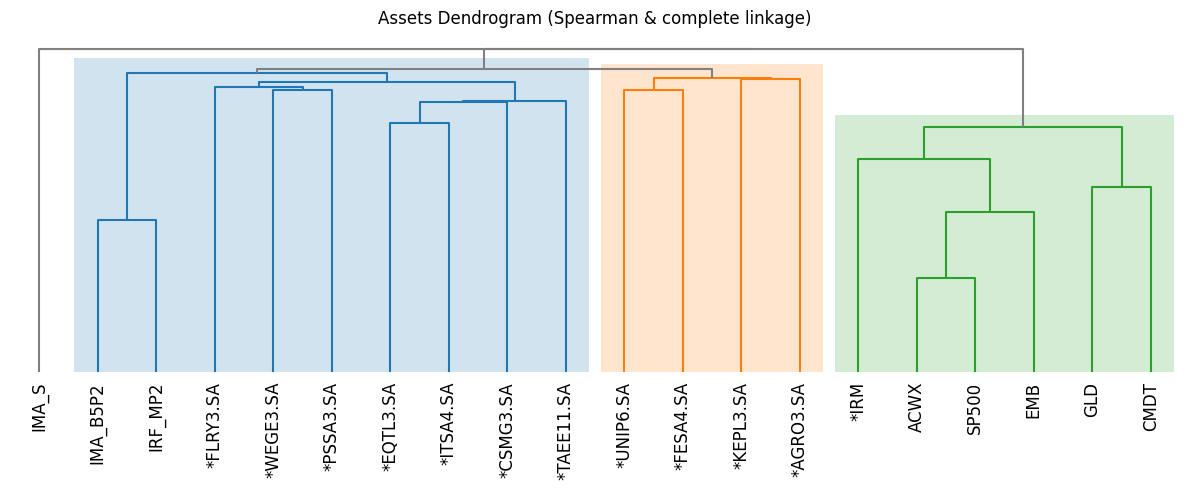

In [ ]:
# @title
############################################################
### Using All Period of Time to Optimize the Final Portfolio
############################################################

### Plotting Assets Clustering
ax = rp.plot_dendrogram(
    returns=log_data,
    codependence='spearman',
    linkage='complete',
    k=None,
    max_k=20,
    leaf_order=True,
    ax=None
)

In [ ]:
### Criação de Tabela com Asset Classes + Tickers
asset_classes = pd.DataFrame(
    {
        'Assets': series_names + ind_data.columns.tolist() + div_data.columns.tolist(),
        'Class': ['Bonds']*len(series_names) + ['Indexes']*len(ind_data.columns) + ['Stocks']*len(div_data.columns)
    }
)
asset_classes = asset_classes.sort_values(by=['Assets'])


### Determinação de Limites
constraints = pd.DataFrame(
    {
        'Disabled': [False, False, False, False, False, False, False, False, False],
        'Type': ['Each asset in a class', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'All Assets', 'All Assets'],
        'Set': ['Class', '', '', '', '', '', '', '', ''],
        'Position': ['Bonds', 'IMA_B5P2', 'EMB', 'GLD', 'CMDT', 'SP500', 'ACWX', '', ''],
        'Sign':     ['>=', '>=', '>=', '>=', '>=', '>=', '>=', '>=', '<='],
        'Weight':   [0.10, 0.15, 0.075, 0.10, 0.04, 0.075, 0.05, 0.01, 0.175],
    }
)

# Determinação dos limites no modelo
w_max, w_min = rp.hrp_constraints(constraints, asset_classes)

In [ ]:
def expand_grid(dictionary):
   return pd.DataFrame(
       [row for row in product(*dictionary.values())]
       ,columns=dictionary.keys()
      )


# Building the portfolio object
port = rp.HCPortfolio(returns=log_data, w_max=w_max, w_min=w_min)

# Estimate optimal portfolio
model='HRP' # Could be HRP or HERC
rf = 0.095 # Risk free rate
max_k = 20 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram
obj = 'Sharpe'
hist = True

linkageList = [
    'complete'
    ,'ward'
    ,'weighted'
    ,'centroid'
    ,'average'
]

covarianceList = [
      'hist','ewma1',
      'shrunk','spectral',
      'shrink','gerber1'
]

codependenceList = [
      'pearson','spearman','kendall',
      'gerber1','abs_pearson',
      'abs_spearman','abs_kendall',
      'distance', 'mutual_info'
  ]

riskmetriclist = [
    'vol','MV','KT','MAD'
    ,'MSV','SKT', 'FLPM'
    ,'SLPM','VaR','CVaR', 'EVaR'
    ,'RLVaR', 'RG', 'CVRG'
    ,'TGRG' ,'MDD','UCI'
    ,'EDaR', 'RLDaR', 'MDD_Rel'
    ,'ADD_Rel', 'EDaR_Rel'
    ,'RLDaR_Rel', 'UCI_Rel'
]

final_grid = expand_grid(
    dictionary = {
        'linkageList': linkageList,
        'covarianceList': covarianceList,
        'codependenceList': codependenceList,
        'riskmetriclist': riskmetriclist
    }
)

resultados = pd.DataFrame()

for i in tqdm(range(len(final_grid))):
  dt = pd.DataFrame({'metrics': ['hash'], 'results': [' | '.join(final_grid.iloc[i])]})

  try:
    w = port.optimization(
        model=model,
        linkage=final_grid['linkageList'][i],
        covariance=final_grid['covarianceList'][i],
        codependence=final_grid['codependenceList'][i],
        rm=final_grid['riskmetriclist'][i],
        obj=obj,
        rf=rf,
        max_k=max_k,
        leaf_order=leaf_order,
        hist=hist
    )
  except:
    pass

  portfolio_return = np.sum(raw_data * w.weights.T, axis=1)

  a = round(timeseries.perf_stats(portfolio_return, factor_returns=raw_ibv['^BVSP']), 5)

  results = pd.DataFrame(data={'metrics': a.index, 'results': a.values})

  dt = pd.concat([dt, results], ignore_index=True).T

  new_header = dt.iloc[0]
  dt = dt[1:]
  dt.columns = new_header

  print(dt[['hash', 'Annual return', 'Annual volatility', 'Max drawdown']].values)

  resultados = pd.concat([resultados, dt], ignore_index=True)

  0%|          | 0/450 [00:00<?, ?it/s]

[['ward | hist | pearson | vol' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | MV' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | KT' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | MAD' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | MSV' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | SKT' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | FLPM' 0.18048 0.10686 -0.17422]]
[['ward | hist | pearson | SLPM' 0.18043 0.10683 -0.17424]]
[['ward | hist | pearson | VaR' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | CVaR' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | EVaR' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | RLVaR' 0.18852 0.10908 -0.18837]]
[['ward | hist | pearson | RG' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | CVRG' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | TGRG' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | MDD' 0.17444 0.09437 -0.119]]
[['ward | hist | pearson | ADD' 0.17444 0.09437 -0.119]]
[['ward | hist | pea

In [ ]:
### [['ward | hist | spearman | RLDaR' 0.19849 0.11871 -0.1677]]

In [ ]:
resultados.sort_values('Cumulative returns', ascending=False).head(5)

In [ ]:
resultados.sort_values('Sharpe ratio', ascending=False).head(5)

In [ ]:
resultados.sort_values('Max drawdown', ascending=False).head(5)

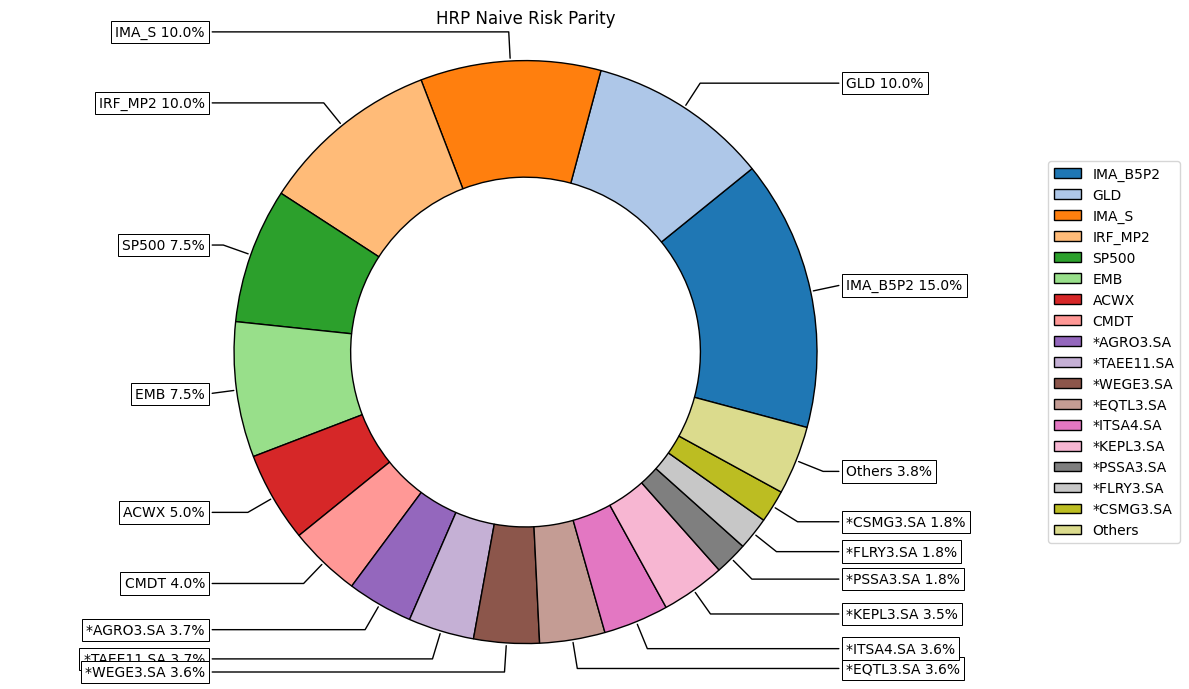

In [ ]:
# Building the portfolio object
port = rp.HCPortfolio(returns=log_train, w_max=w_max, w_min=w_min)

# Estimate optimal portfolio
model='HRP' # Could be HRP or HERC

# Maior Sharpe - centroid | ewma1 | abs_spearman | MDD
linkage = 'complete' # Linkage method used to build clusters
covariance = 'hist'
codependence = 'spearman' # Correlation matrix used to group assets in clusters
rm = 'SLPM' # Risk measure used, this time will be variance

rf = 0.095 # Risk free rate
max_k = 20 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
obj = 'Sharpe'
hist = True

w = port.optimization(
    model=model,
    codependence=codependence,
    covariance=covariance,
    obj=obj,
    rm=rm,
    rf=rf,
    linkage=linkage,
    max_k=max_k,
    leaf_order=leaf_order,
    hist=hist
)

# Plotting the composition of the portfolio
ax = rp.plot_pie(
    w=w,
    title='HRP Naive Risk Parity',
    others=0.05,
    nrow=30,
    cmap="tab20",
    height=7,
    width=12,
    ax=None
)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.93,2020-02-21,2020-03-23,2020-04-28,48
1,6.22,2015-10-22,2016-01-20,2016-02-22,88
2,6.06,2011-04-07,2011-08-08,2011-08-31,105
3,5.28,2022-03-18,2022-07-11,2022-08-04,100
4,4.72,2015-08-04,2015-08-24,2015-09-11,29


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.26%,-2.44%,2.08%
Fukushima,0.07%,-0.68%,0.90%
EZB IR Event,0.05%,-0.49%,0.81%
Flash Crash,0.08%,-0.10%,0.17%
Apr14,0.05%,-0.60%,0.97%
Oct14,-0.03%,-1.16%,1.86%
Fall2015,0.15%,-2.16%,1.69%
Recovery,0.06%,-2.44%,2.28%
New Normal,0.06%,-2.26%,3.58%
Covid,0.06%,-4.96%,4.27%


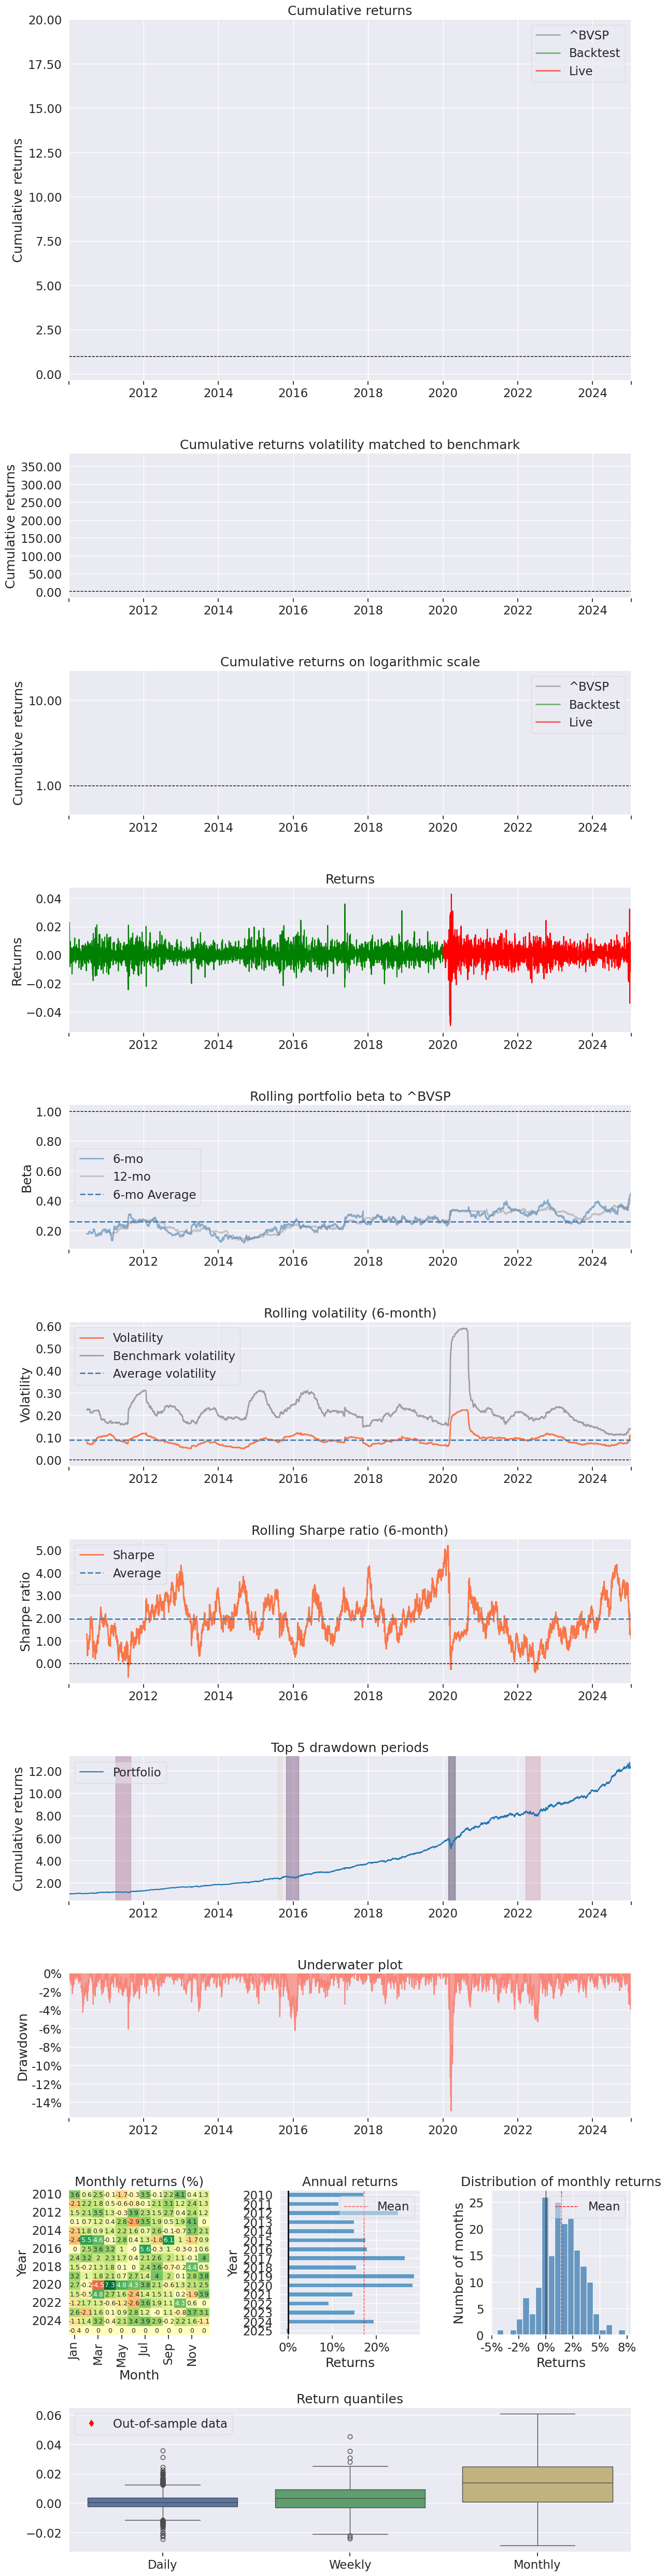

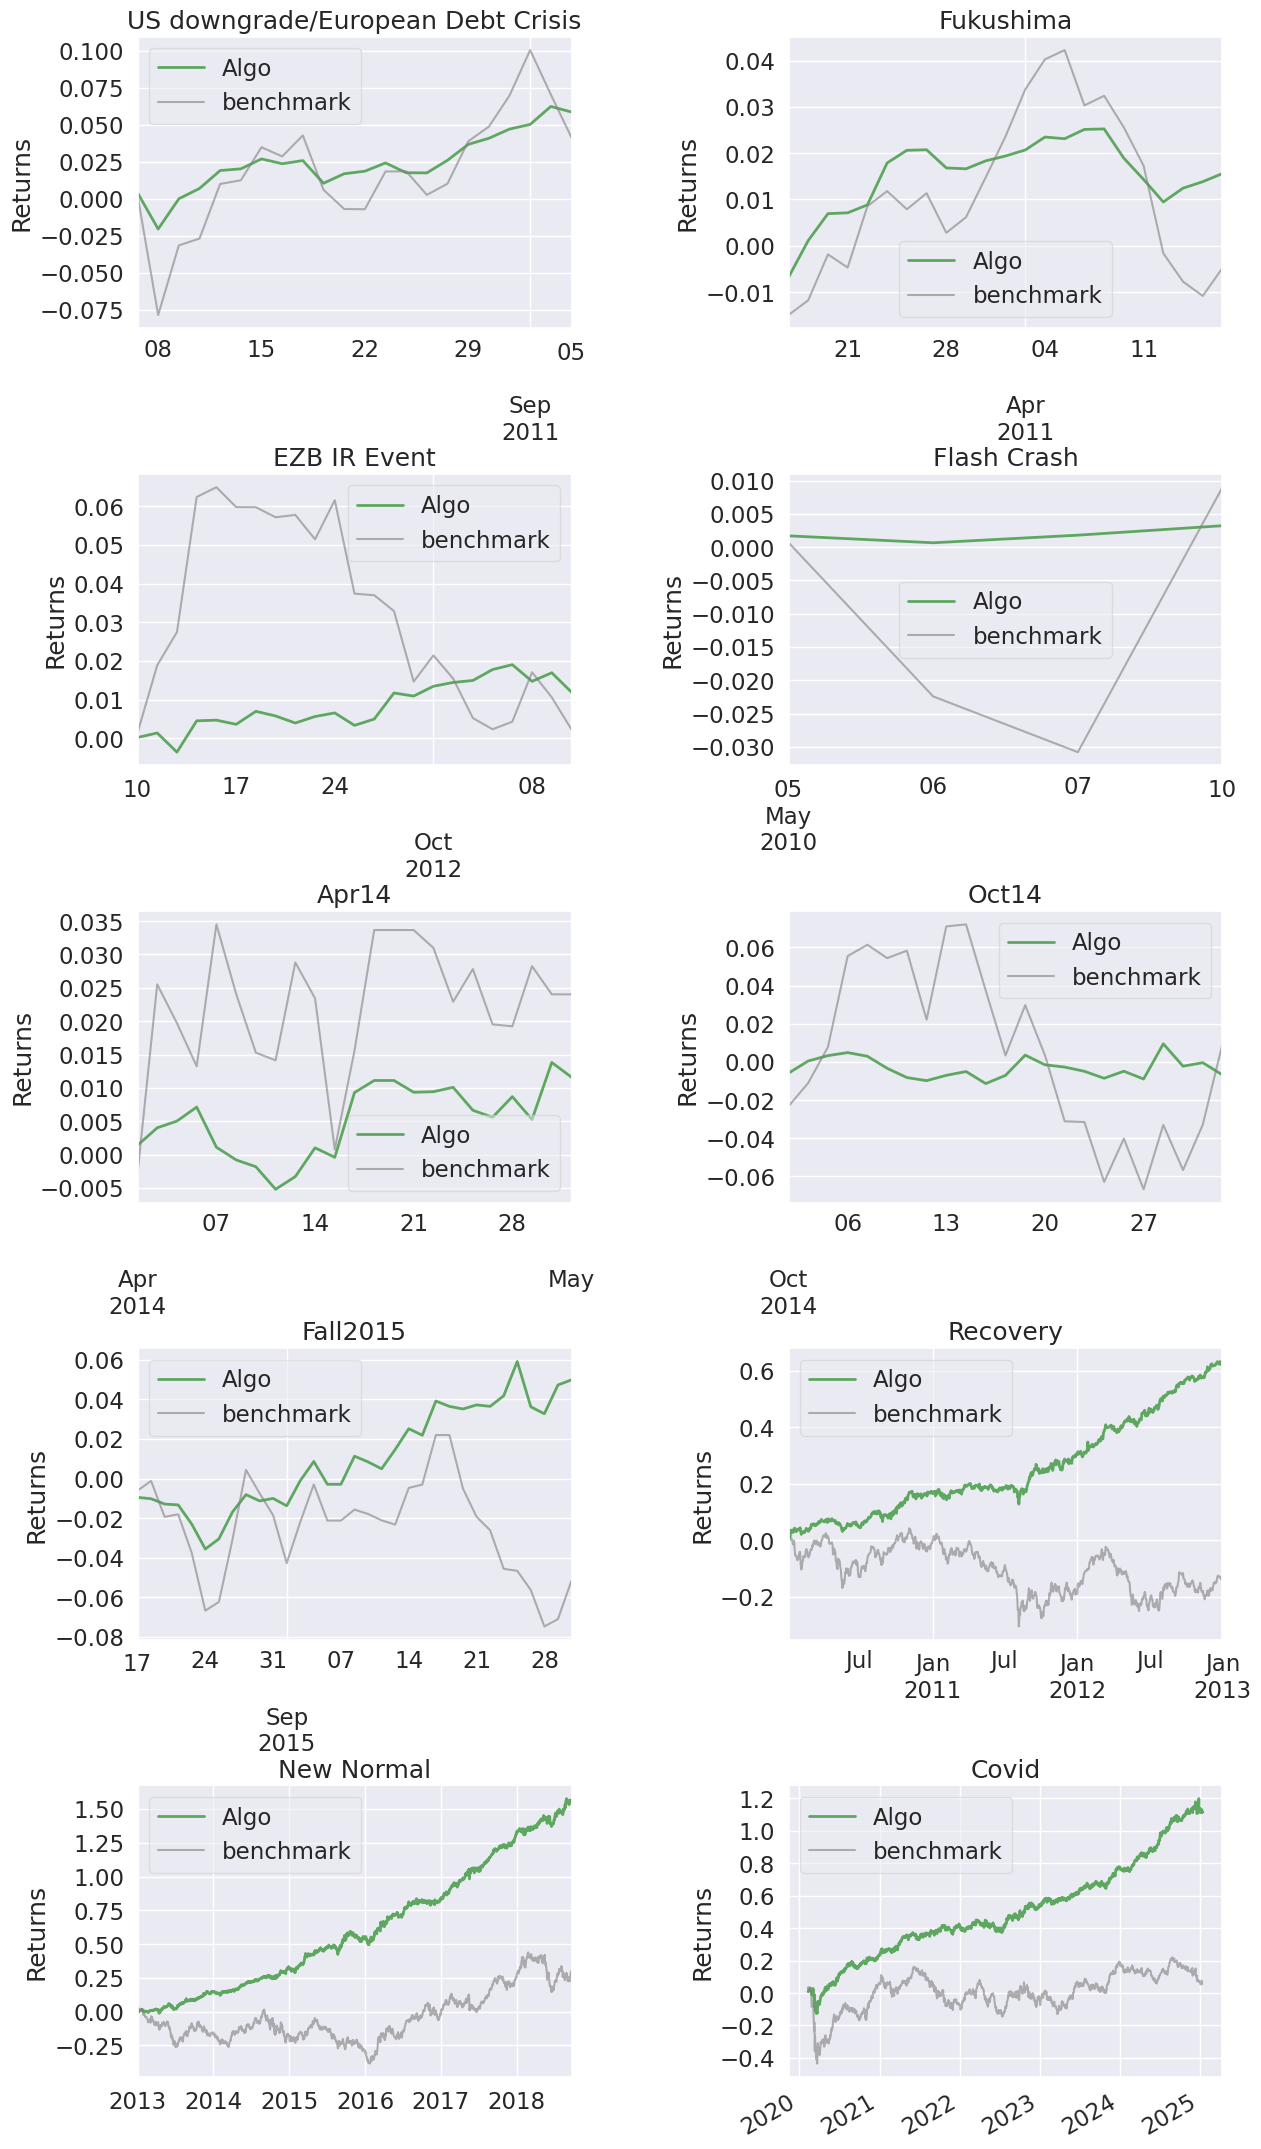

In [ ]:
### Base necessária para executar - depois validar o erro que acontece sem ela
test_ibv = data_ibv.pct_change().dropna()

### Otimização de Portfolio - Treino vs Validação
portfolio_return = np.sum(raw_data * w.weights.T, axis=1)

pf.create_full_tear_sheet(
    portfolio_return,
    live_start_date=live_date,
    benchmark_rets=test_ibv['^BVSP']
)

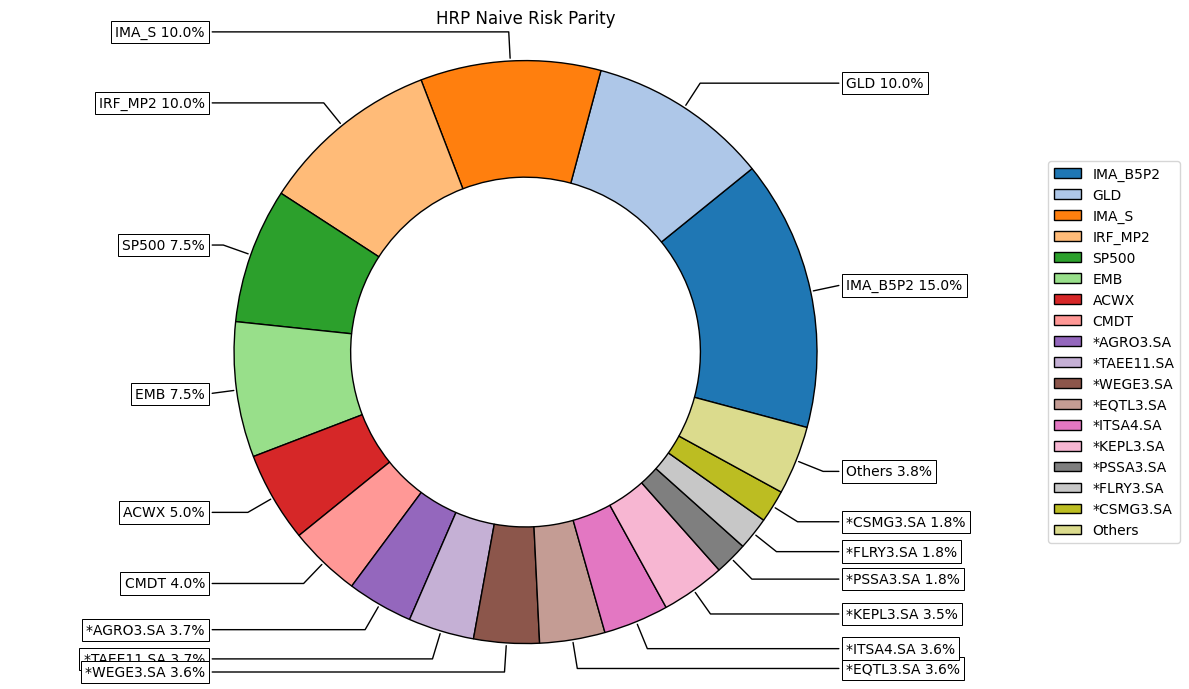

In [ ]:
# Building the portfolio object
port = rp.HCPortfolio(returns=log_train, w_max=w_max, w_min=w_min)

w = port.optimization(
    model=model,
    linkage=linkage,
    covariance=covariance,
    codependence=codependence,
    rm=rm,
    obj=obj,
    rf=rf,
    max_k=max_k,
    leaf_order=leaf_order,
    hist=hist
)

# Plotting the composition of the portfolio
ax = rp.plot_pie(
    w=w,
    title='HRP Naive Risk Parity',
    others=0.05,
    nrow=30,
    cmap="tab20",
    height=7,
    width=12,
    ax=None
)

Start date,2010-01-05
End date,2025-01-10
Total months,186
,Backtest
Annual return,17.484%
Cumulative returns,1124.57%
Annual volatility,9.49%
Sharpe ratio,1.75
Calmar ratio,1.17
Stability,1.00
Max drawdown,-14.93%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.93,2020-02-21,2020-03-23,2020-04-28,48
1,6.22,2015-10-22,2016-01-20,2016-02-22,88
2,6.06,2011-04-07,2011-08-08,2011-08-31,105
3,5.28,2022-03-18,2022-07-11,2022-08-04,100
4,4.72,2015-08-04,2015-08-24,2015-09-11,29


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.26%,-2.44%,2.08%
Fukushima,0.07%,-0.68%,0.90%
EZB IR Event,0.05%,-0.49%,0.81%
Flash Crash,0.08%,-0.10%,0.17%
Apr14,0.05%,-0.60%,0.97%
Oct14,-0.03%,-1.16%,1.86%
Fall2015,0.15%,-2.16%,1.69%
Recovery,0.06%,-2.44%,2.28%
New Normal,0.06%,-2.26%,3.58%
Covid,0.06%,-4.96%,4.27%


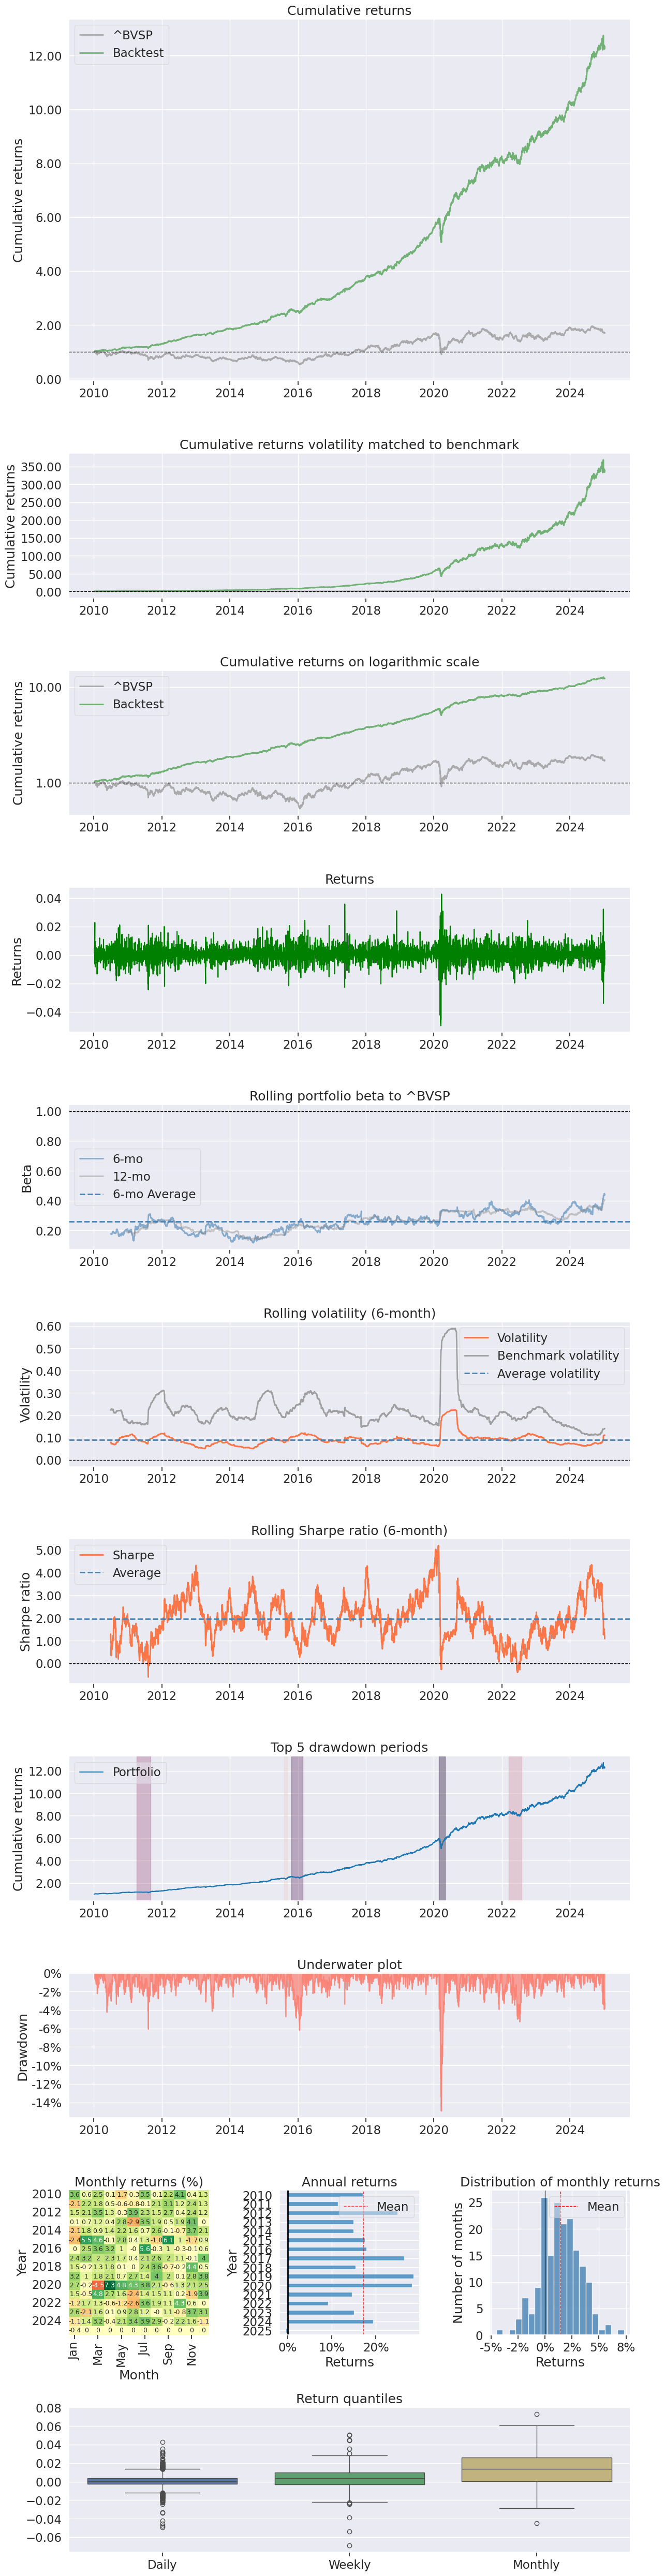

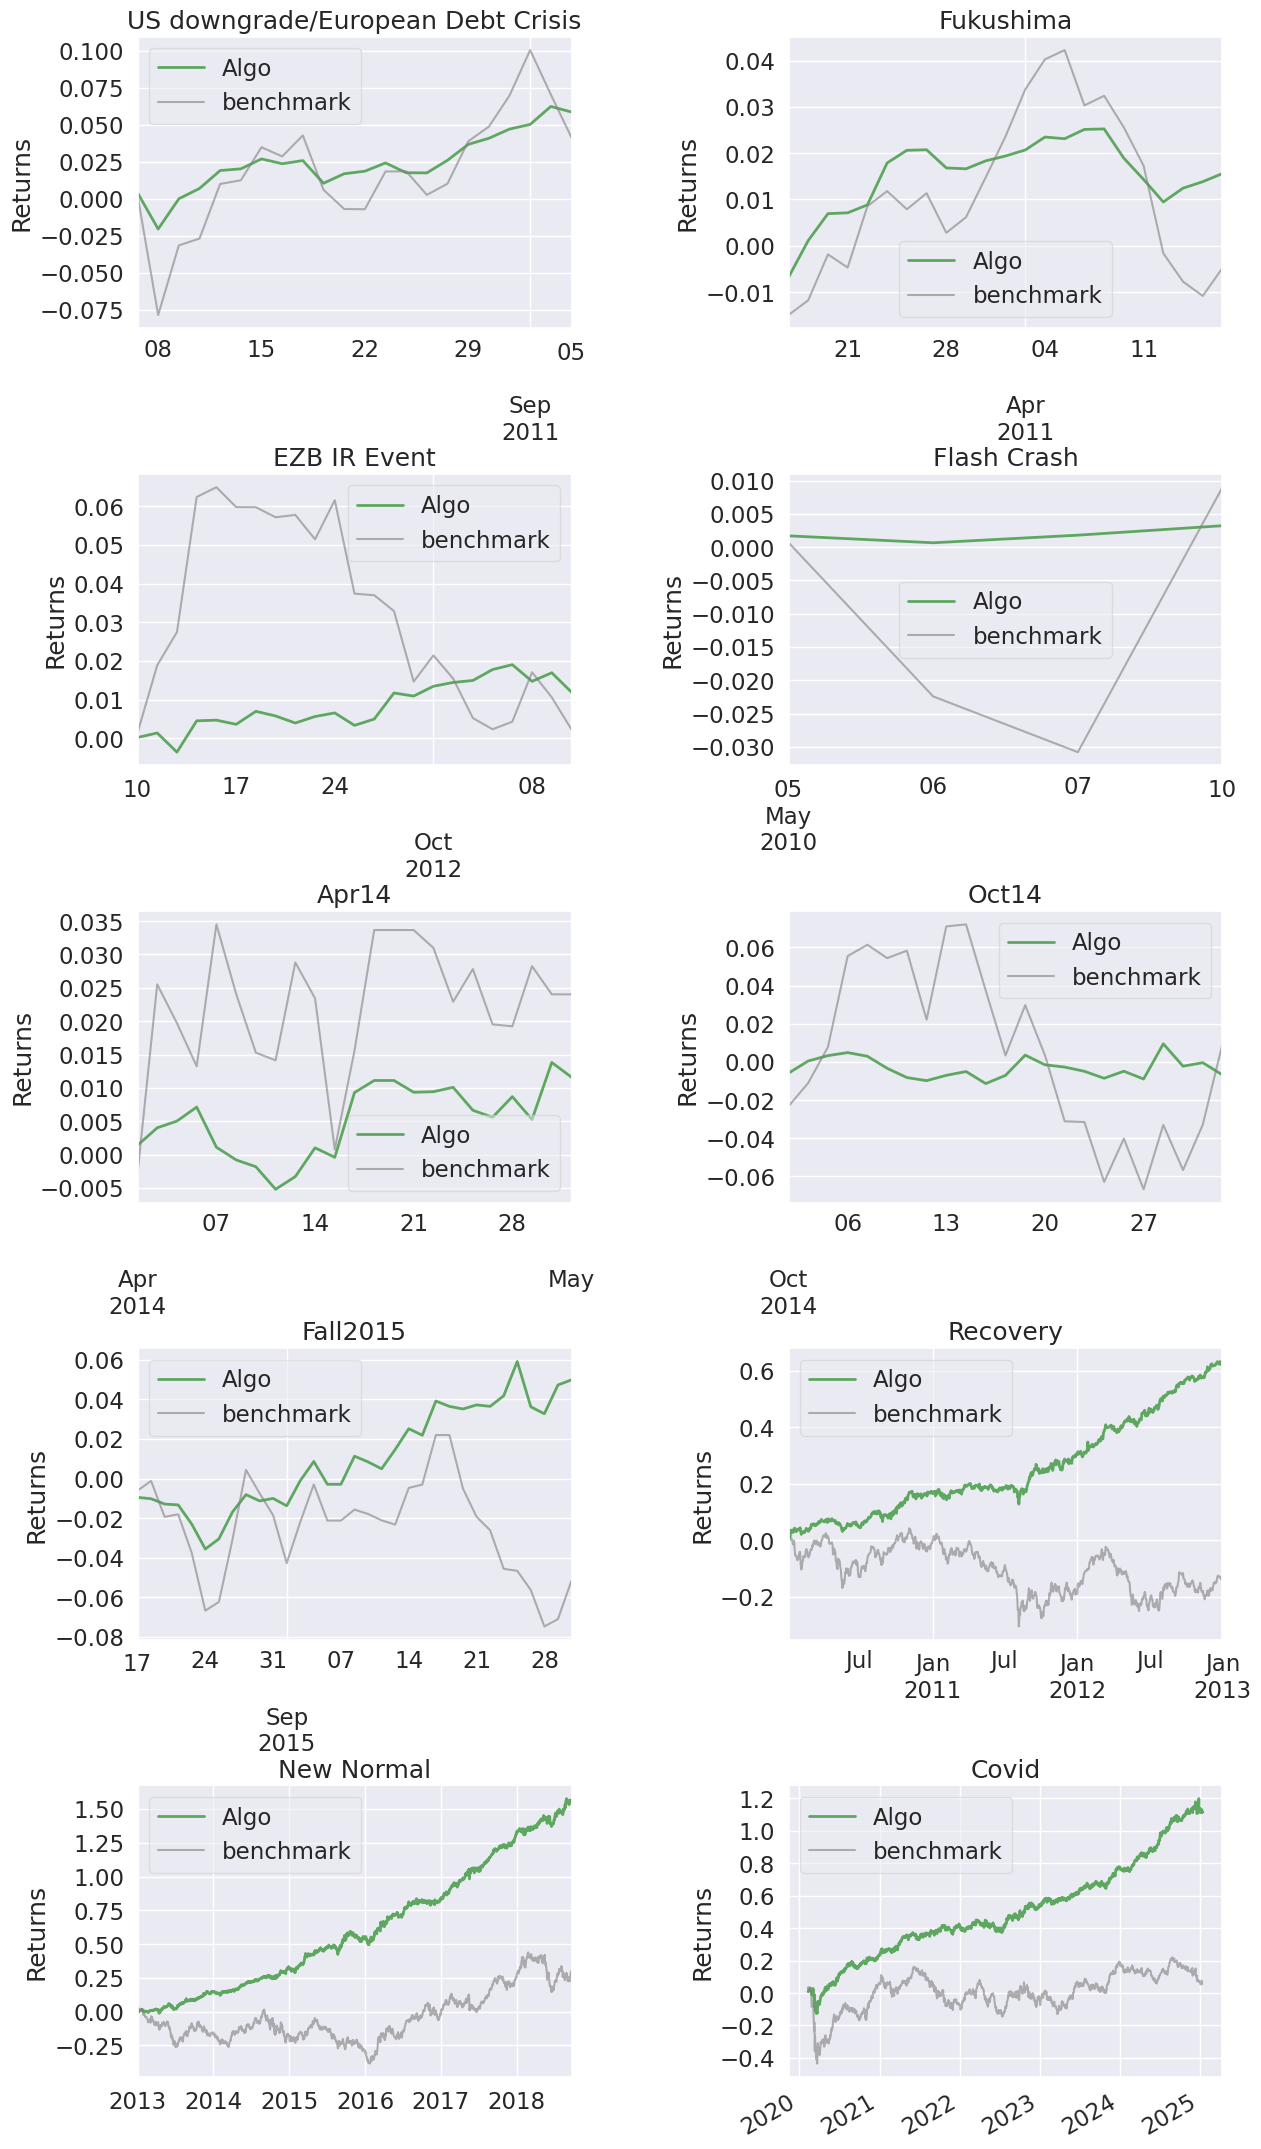

In [ ]:
portfolio_return = np.sum(raw_data * w.weights.T, axis=1)

pf.create_full_tear_sheet(
  portfolio_return,
  benchmark_rets=raw_ibv['^BVSP']
)

In [ ]:
savings = 21000

preco = data.tail(1).T
preco.columns = ['preco']

my_port = (
    pd.DataFrame(
      {
      'ticker': w.index,
      'pesos': round(w['weights'] * 100, 2),
      'valor': round(w['weights'] * savings, 2),
      }
    )
    .sort_values(by=['pesos'], ascending=False)
    .reset_index(drop=True)
)

my_port

,ticker,pesos,valor
0,IMA_B5P2,15.000,3150.000
1,GLD,10.000,2100.000
2,IMA_S,10.000,2100.000
3,IRF_MP2,10.000,2100.000
4,SP500,7.500,1575.000
5,EMB,7.500,1575.000
6,ACWX,5.000,1050.000
7,CMDT,4.000,840.000
8,*TAEE11.SA,3.650,767.110
9,*AGRO3.SA,3.650,767.390
